# Bayesian modeling & PyMC3

PyMC3?

> - PyMC3 библиотека, у которой "под капотом" [Theano](http://deeplearning.net/software/theano/). Бибилиотека быстрых вычислений с синтаксисом Numpy

> - Работает с тензорам , похожими на ndarray структуру данных


Отлично подходит для:

- [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method)
- Работы с Байесовскими моделями

### Важные термины

- Апостериорный - Опирающийся на опыт, основанный на знании фактов
- Априори / приори - Знание, полученное до опыта и независимо от него

## Bayes Theorem

**Частотный вывод** - это метод статистического вывода, в котором выводы из данных получаются путем вычисления частоты из пропорции данных.

**Байесовский вывод** - это метод статистического вывода, в котором теорема Байеса используется для обновления вероятности гипотезы по мере поступления новых доказательств или информации.

#### Частотный вывод

Пусть $A$ и $B$ - два события, тогда *условная вероятность* $A$ при заданном $B$ определяется как отношение

$$
P(A|B):=\frac{P(A\cap B)}{P(B)}
$$


#### Bayes Theorem

\begin{equation}
P(A|B)=\frac{P(B|A)P(A)}{P(B)}
\end{equation}


Пусть событие B — машина не заводится, а гипотеза A — в баке нет топлива. Вероятность **P(B|A)**, что машина не заведётся, если в баке нет топлива, равняется единице.

Как следствие, апостериорная вероятность, что в баке нет топлива, если машина не заводится, то есть **P(A|B)**, то есть отношению априорной вероятности, что в баке нет топлива, к вероятности, что машина не заводится.

Например, если априорная вероятность, что в баке нет топлива, равна 0,01, а вероятность, что машина не заводится, равна 0,02, и случайно выбранная машина не завелась, то вероятность, что в её баке нет топлива, равна 0,5 (0.02/0.01)



**Пример:** В МК мы знаем, что покупатель купит кошачий корм, мы хотим узнать, с какой вероятностью это будет мужчина. Событие $A=\text{мужчинка}$ and $B= \text{купил кискин корм}$. Мы хотим узнать $P(A|B)$. Мы уже знаем, что $P(A)=0.5$, $P(B)=0.4$ и $P(B|A)=0.7$ (вероятность того, что корм куплен и это мужчина). Результат будет такой.

\begin{equation}
P(A|B)=\frac{P(B|A)P(A)}{P(B)} = \frac{0.7\times 0.5}{0.4} = 0.875.
\end{equation}

#### В нашей дата аналитике


$$
f(\theta|y)=\frac{f(y|\theta)f(\theta)}{f(y)} = 
\displaystyle{\frac{f(y|\theta)f(\theta)}{\int f(y|\theta)f(\theta)d\theta}}
$$

- Функция правдоподобия $f(y|\theta)$

- $f(\theta)$ ожидаемое (считаем, что предварительное) распределение из $\theta$  (В англ. использую prior)


Из-за сложности вычислений, это можно свести до формулы

$$
f(\theta|y)  \propto \text{likelihood} \times \text{prior}.
$$


## Пример: Poisson

[Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution)

$$
f(y_i|\lambda)=\frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
$$


In [81]:
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.stats as ss
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [10, 7]

%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'png'

### Генерация данных

In [82]:
SEED = 28
np.random.seed(SEED)

# размер
n = 100

# true 
lam_true = 2

# 
y = np.random.poisson(lam=lam_true, size=n)

y

array([2, 3, 5, 0, 3, 2, 5, 0, 1, 2, 2, 3, 0, 3, 0, 3, 3, 3, 0, 4, 3, 3,
       2, 1, 3, 1, 3, 6, 1, 0, 3, 2, 2, 3, 1, 1, 2, 2, 1, 1, 3, 1, 5, 1,
       2, 1, 1, 3, 2, 3, 1, 1, 2, 1, 1, 1, 0, 5, 3, 1, 2, 2, 3, 1, 3, 3,
       2, 1, 1, 2, 3, 4, 4, 3, 0, 4, 2, 4, 1, 1, 2, 4, 1, 1, 2, 0, 1, 0,
       2, 3, 1, 3, 0, 2, 3, 4, 3, 3, 0, 3])

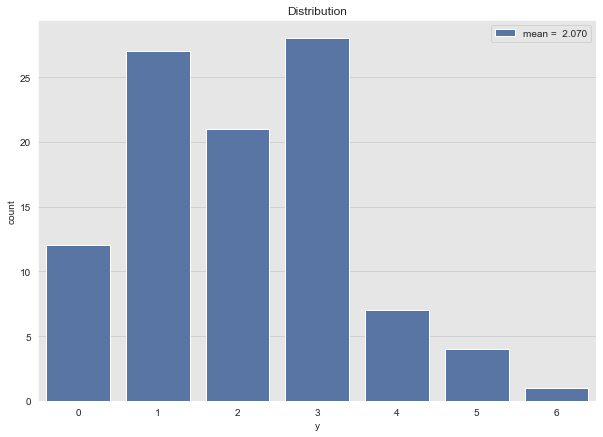

In [83]:
# Визуализируем
fig, ax = plt.subplots()
sns.countplot(x=y, color=sns_c[0], label=f'mean = {y.mean(): 0.3f}', ax=ax)
ax.legend(loc='upper right')
ax.set(title='Distribution', xlabel='y');

### Ожидаемое (считаем, что предварительное): Gamma Distribution

[gamma](https://en.wikipedia.org/wiki/Gamma_distribution) 

$$
f(\lambda)=\frac{b^a}{\Gamma(a)}\lambda^{a-1} e^{-b\lambda}
$$

Примем за услове $a>0$ и $b>0$ 

*Ожидаемое значение* и *Вариативность* в данном распределении 

$$
E(\lambda)=\frac{a}{b}
\quad
\text{и}
\quad
Var(\lambda)=\frac{a}{b^2}
$$

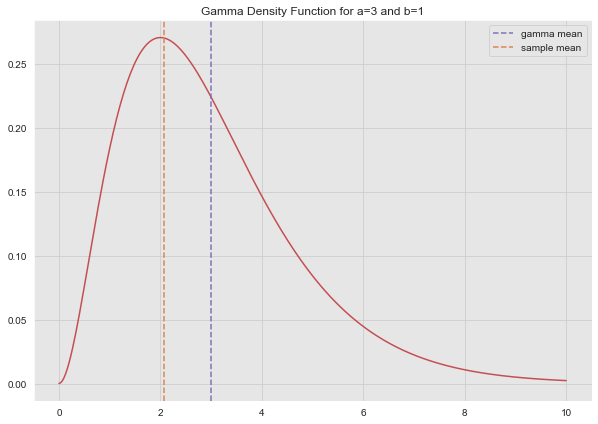

In [84]:
# Создадим распределение
a = 3 # shape
b = 1 # rate = 1/scale

x = np.linspace(start=0,stop=10, num=300)

fig, ax = plt.subplots()
ax.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), color=sns_c[3])
ax.axvline(x= a /b, color=sns_c[4], linestyle='--', label='gamma mean')
ax.axvline(x= y.mean(), color=sns_c[1], linestyle='--', label='sample mean')
ax.legend()
ax.set(title=f'Gamma Density Function for a={a} and b={b}');

In [85]:
# определим ожидаемое распределение
prior = lambda x: ss.gamma.pdf(x, a=a, scale=1/b)

### Правдоподобие

[likelihood](https://en.wikipedia.org/wiki/Likelihood_function)

$$
f(y|\lambda)=\prod_{i=1}^{n} \frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
=\frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^{n}y_i!}
$$

In [86]:
# Определим функцию
def likelihood(lam, y):
    
    factorials = np.apply_along_axis(
        lambda x: sp.gamma(x + 1),
        axis=0,
        arr=y
    )
    
    numerator = np.exp(- lam * y.size) * (lam ** (y.sum()))
    
    denominator = np.multiply.reduce(factorials)
    
    return numerator / denominator  

### Вычислим распределение фактическое (posterior), где $\lambda$ будет константой


\begin{align}
f(\lambda|y)\propto & \: \text{likelihood} \times \text{prior}\\
\propto & \quad f(y|\lambda)f(\lambda)\\
\propto & \quad e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i} \lambda^{a-1} e^{-b\lambda}\\
\propto & \quad \lambda^{\left(\sum_{i=1}^n y_i+a\right)-1} e^{-(n+b)\lambda}\\
\end{align}

In [87]:
# posterior distribution
def posterior_up_to_constant(lam, y):
    return likelihood(lam=lam, y=y) * prior(lam)

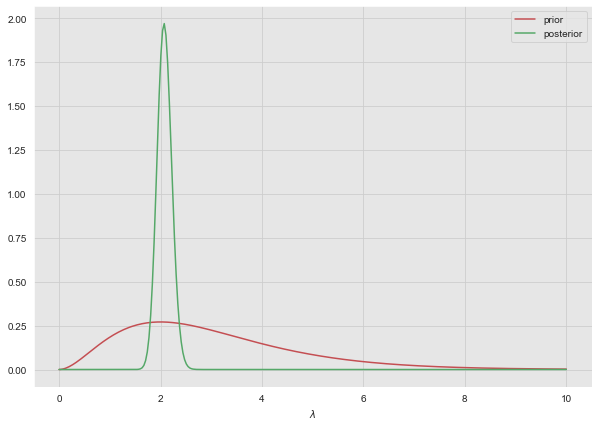

In [88]:
fig, ax = plt.subplots()
ax.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), color=sns_c[3], label='prior')
ax.plot(x, 2.0e74 * posterior_up_to_constant(x,y), color=sns_c[2], label='posterior')
ax.legend()
ax.set(xlabel='$\lambda$');

## Markov Chain Monte Carlo  (MCMC) 

Часто, фактическое значение вычислить сложнее. Поэтому нам необходимы методы моделирования методов моделирования (такие как Монте-Карло).

Рассмотрим на примере алгоритма Метрополиса–Гастингса

### Metropolis–Hastings algorithm

$\phi$ это ожидаемое распределение функции $f$. 

**Установка:**

 $x_{0}$ первое распределение

\begin{equation}
g(x_{n+1}| x_{n})
\end{equation}

**Итерации:**

Создаем кандидатов $x$ из распределения $g(x|x_n)$

\begin{equation}
\alpha := \frac{f(x)}{f(x_n)} = \frac{\phi(x)}{\phi(x_n)}
\end{equation}

Если $\alpha \geq 1$, то кандидат принимается 

\begin{equation}
x_{n+1} = x.
\end{equation}

Иначе

\begin{equation}
x_{n+1} = x_{n}.
\end{equation}

In [89]:
with pm.Model() as toy_model:
    # prior lambda
    lam = pm.Gamma('lambda', alpha=a, beta=b)
    # likelihood function
    y_obs = pm.Poisson('y_obs', mu=lam, observed=y)

#pm.model_to_graphviz(toy_model)

In [90]:
with toy_model:
    # 400 итераций и 4 сэмпла
    trace = pm.sample(
        tune=100,
        draws=400,
        chains=4,
        cores=-1,
        return_inferencedata=True
    )

Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [lambda]


Sampling 4 chains for 100 tune and 400 draw iterations (400 + 1_600 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9328881450317144, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9416026626039935, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9440997979435509, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9234186145713753, but should be close to 0.8. Try to increase the number of tuning steps.


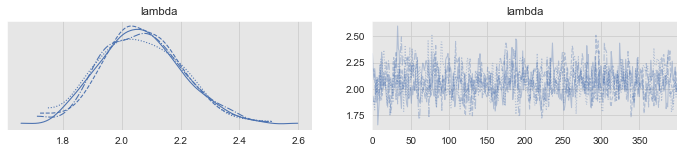

In [91]:
from arviz.utils import Numba
Numba.disable_numba()
az.plot_trace(data=trace);

In [92]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,2.069,0.139,1.811,2.328,0.006,0.004,592.0,889.0,1.0


- TОжидаемое значение $\lambda$ близко к $2$.
- `r_hat` это тестовый параметр [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html#gelman-rubin-statistic), показывающий возможность сближения данных распределений (от  0 )

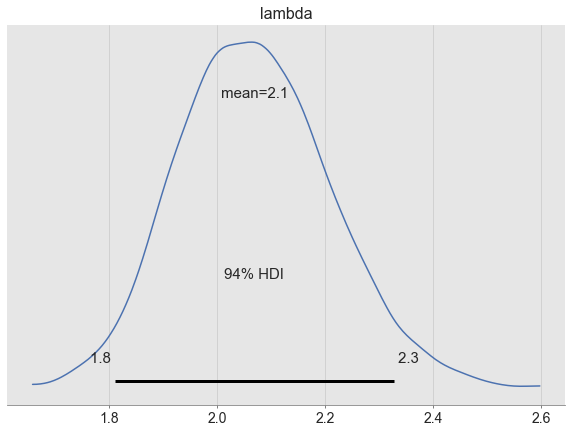

In [93]:
fig, ax = plt.subplots()
az.plot_posterior(data=trace, ax=ax);

Теперь перестроим модель на уже известном параметре $\lambda$.

In [94]:
with toy_model:
    
    forecast_1 = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace=trace)
    )

posterior_sampels = forecast_1.posterior_predictive['y_obs'].values.flatten()

In [96]:
posterior_sampels

array([1, 2, 1, ..., 3, 1, 2])

Сравним результаты

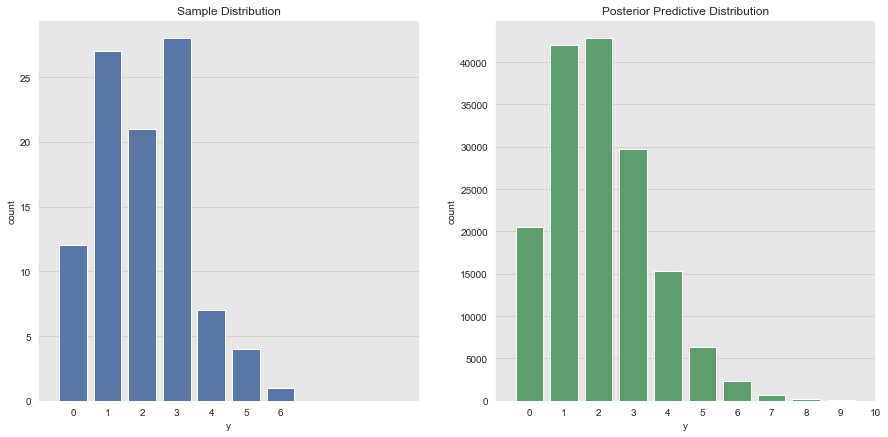

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.countplot(x=y, color=sns_c[0], ax=ax[0])
ax[0].set(title='Sample Distribution', xlabel='y', xlim=(-1, 10))
sns.countplot(x=posterior_sampels, color=sns_c[2], ax=ax[1])
ax[1].set(title='Posterior Predictive Distribution', xlabel='y', xlim=(-1, 10));

## Bayesian Hierarchical Modeling: Рабочий пример


In [98]:
import random

cookies = pd.DataFrame(columns = ['chips', 'location'])

cookies['chips'] = [random.randint(1, 20) for _ in range(0, 500)]
cookies['location'] = [random.randint(1, 4) for _ in range(0, 500)]

cookies.head(5)

,chips,location
0,13,4
1,14,3
2,1,4
3,15,2
4,2,3


In [99]:
cookies.value_counts('location')

location
2    137
4    127
1    121
3    115
dtype: int64

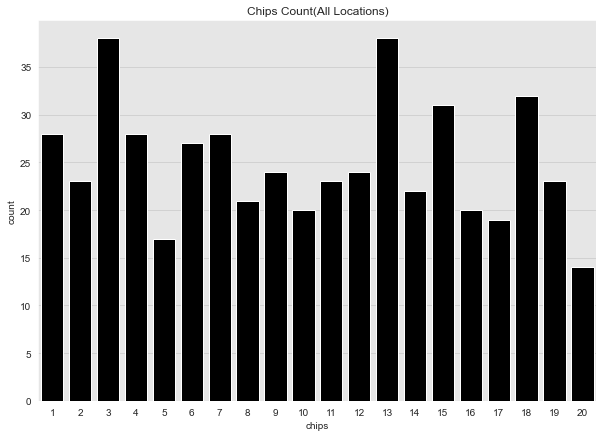

In [100]:
# H_distribution
fig, ax = plt.subplots()
sns.countplot(x='chips', data=cookies, color='black', ax=ax);
ax.set(title='Chips Count(All Locations)');

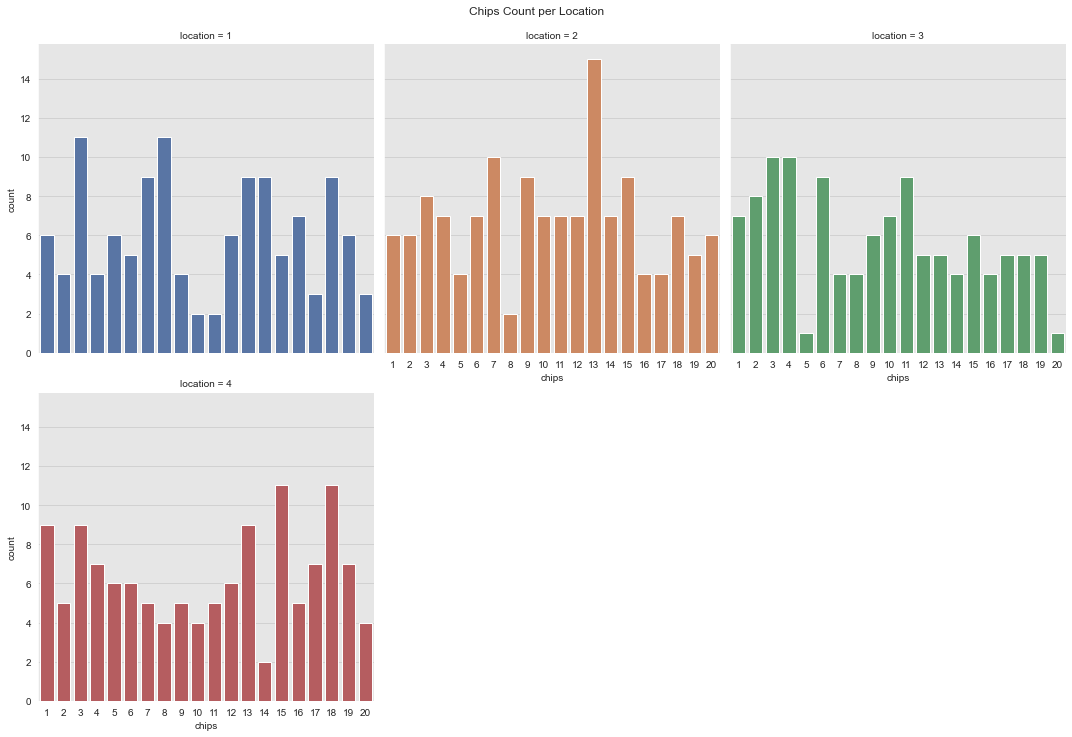

In [101]:
g = sns.catplot(
    x='chips',
    data=cookies,
    col='location',
    hue='location',
    kind='count',
    dodge=False,
    col_wrap=3
)
g.fig.suptitle('Chips Count per Location', y=1.02);

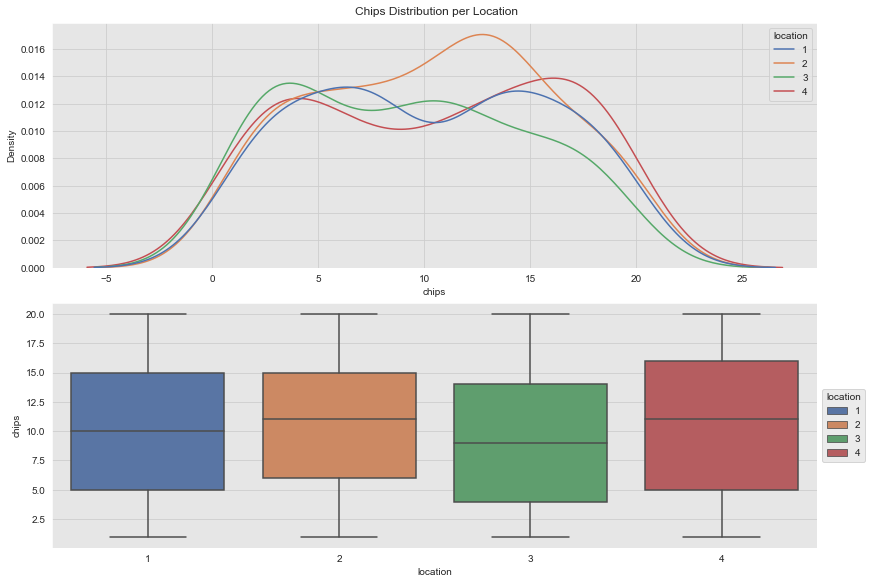

In [103]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True
)
sns.kdeplot(
    x='chips',
    data=cookies,
    hue='location',
    palette=sns_c[:4],ax=ax[0]
)
sns.boxplot(
    x='location',
    y='chips',
    data=cookies,
    hue='location',
    palette=sns_c[:4],
    dodge=False,
    ax=ax[1]
)
ax[1].legend(title='location', loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Chips Distribution per Location');

С учетом этих графиков и постановки задачи можно было бы рассмотреть следующие аспекты для моделирования данных:

- С одной стороны, можно было бы предположить, что распределение по локациям схоже. Можно объединить все локации в одну.

- С другой стороны, в действительности, поскольку местоположения не совсем одинаковы, вы можете ожидать некоторых различий между каждым местоположением. Каждая локация в отдельности

Иерархические модели - отличный способ сделать это. Как? Что ж, мы можем предположить 3 различных параметров для каждого местоположения, но все они исходят из общего глобального (гипер) априорного распределения.

### Описание модели: Hierarchical Approach

- Модель:

\begin{align}
\text{chips} \sim  \text{Pois}(\lambda)
\quad\quad\quad
\lambda \sim  \Gamma(\alpha, \beta)
\end{align}

- Параметры:

\begin{align}
\alpha =\frac{\mu^2}{\sigma^2}
\quad\quad\quad
\beta=\frac{\mu}{\sigma^2}
\end{align}

- Ожидаемое распределение:


\begin{align}
\mu  \sim  \Gamma(2,1/5)
\quad\quad\quad
\sigma  \sim  \text{Exp}(1)
\end{align}

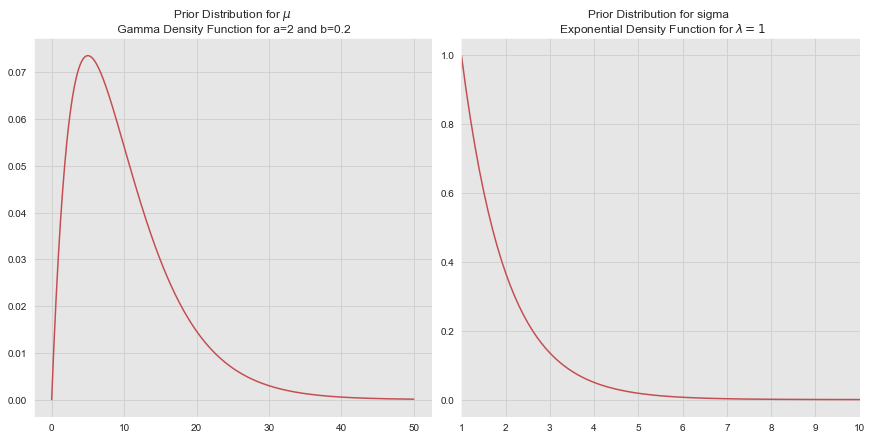

In [104]:
x = np.linspace(start=0, stop=50, num=500)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True
)
ax[0].plot(x, ss.gamma.pdf(x, a=2, scale=5), color=sns_c[3])
ax[0].set(
    title=f'Prior Distribution for $\mu$ \n Gamma Density Function for a={2} and b={1/5}'
)
ax[1].plot(x, ss.expon.pdf(x,1), color=sns_c[3])
ax[1].set(
    title='Prior Distribution for sigma \n Exponential Density Function for $\lambda=1$',
    xlim=(1, 10)
);

### Модель на PyMC3

In [105]:
# Создаем переменные с нашими данным, устанавливаем их, как координаты
chips = cookies['chips'].values
location_idx, locations = cookies['location'].factorize(sort=True)

COORDS = {
    'obs': cookies.index,
    'location': locations
}

In [106]:
with pm.Model(coords=COORDS) as cookies_model:
    # Hyperpriors:
    # Ожидаемое распределение для mu.
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    # Ожидаемое распределение для sigma2.
    sigma = pm.Exponential('sigma', 1.0)
    # Параметры размерности.
    alpha =  pm.Deterministic('alpha', mu**2 / sigma**2)
    # Параметры скалирования.
    beta = pm.Deterministic('beta', mu / sigma**2)
    
    # Ожидаемое распределение для lambda.
    lam = pm.Gamma(
        'lam', 
        alpha=alpha, 
        beta=beta, 
        dims='location'
    )
    
    # Likehood.
    rate = lam[location_idx]
    likelihood = pm.Poisson(
        'likelihood',
        mu=rate,
        observed=chips,
        dims='obs'
    )
    
    # Сэмпл данных ожидаемого распределения
    prior_predictive = pm.sample_prior_predictive()

#pm.model_to_graphviz(cookies_model)

#### Что модель определеяет, до того как она увидит данные

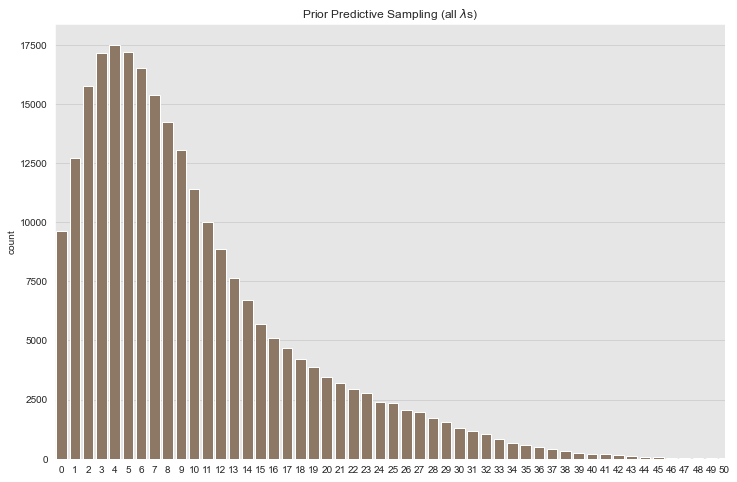

In [107]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(
    x=prior_predictive['likelihood'].flatten(), 
    color=sns_c[5],
    ax=ax
)
ax.set(
    title='Prior Predictive Sampling (all $\lambda$s)', 
    xlim=(None, 50)
);

#### Обучим модель

In [108]:
with cookies_model:

    cookies_trace =pm.sample(
        tune=10,
        draws=40,
        chains=4,  
        cores=4,
        return_inferencedata=True,
        target_accept=0.95
    )
    
    # добавляем наших ожиданий 
    posterior_predictive = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace=cookies_trace)
    )

Only 40 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, sigma, mu]


Sampling 4 chains for 10 tune and 40 draw iterations (40 + 160 draws total) took 94 seconds.
C:\Users\ArtSe\AppData\Local\Programs\Python\Python38\lib\site-packages\pymc3\sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


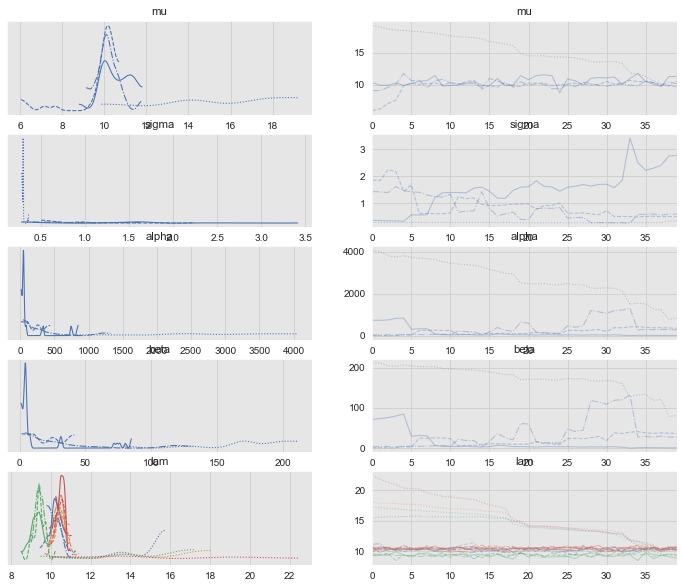

In [109]:
az.plot_trace(cookies_trace);

Расчет среднего для всех распределений

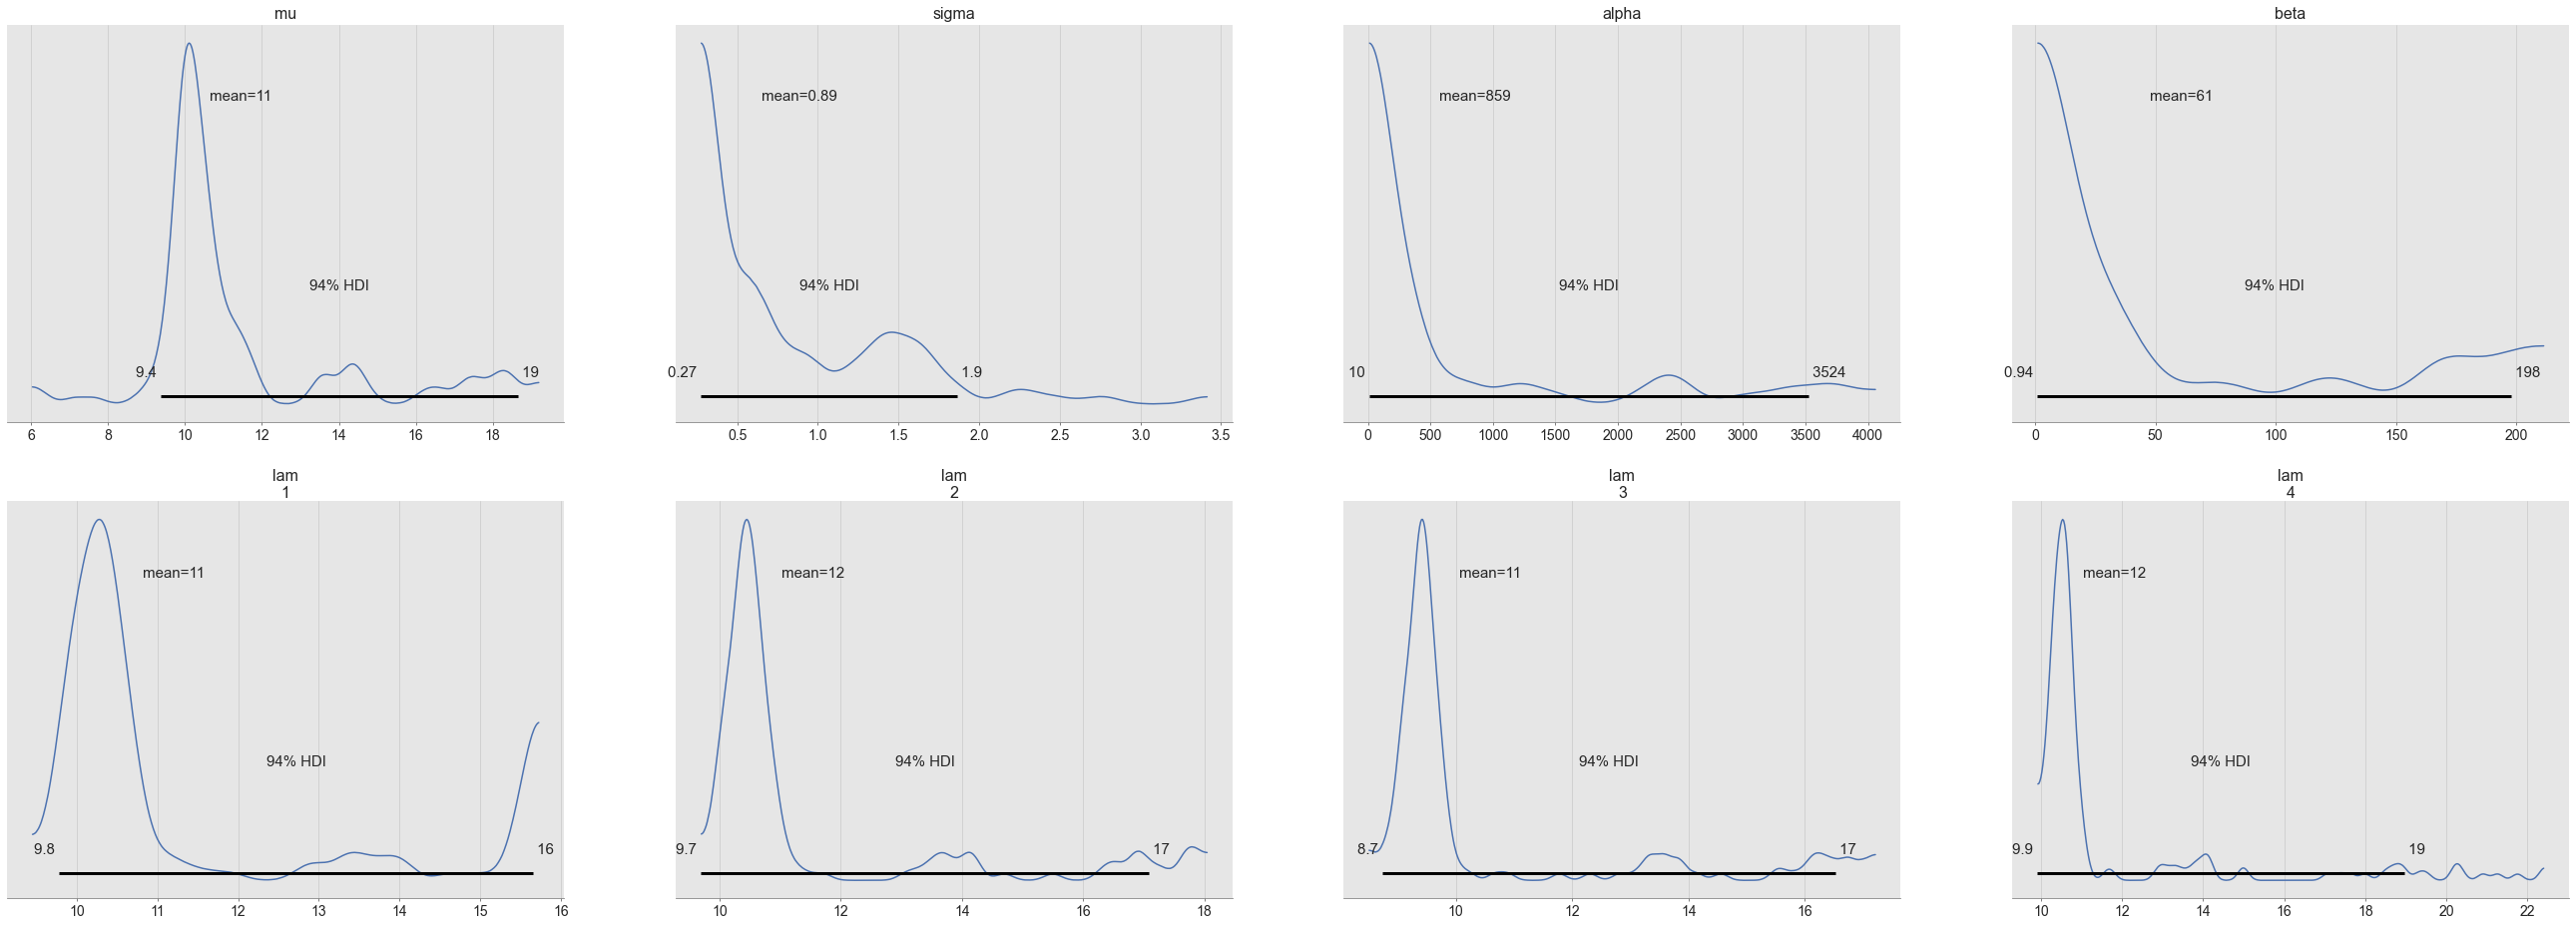

In [110]:
az.plot_posterior(cookies_trace);

Общая статистика

In [111]:
az.summary(cookies_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,11.442,2.689,9.368,18.652,1.136,0.861,8.0,13.0,1.60
sigma,0.885,0.639,0.275,1.864,0.242,0.179,7.0,18.0,2.05
alpha,859.247,1192.751,10.055,3523.938,516.271,387.103,6.0,13.0,2.17
beta,60.869,71.365,0.942,197.934,30.308,23.043,6.0,13.0,2.28
lam[1],11.206,1.889,9.781,15.656,0.812,0.612,9.0,14.0,1.50
lam[2],11.544,2.294,9.693,17.082,0.989,0.744,10.0,13.0,1.47
lam[3],10.594,2.435,8.735,16.523,1.051,0.790,8.0,13.0,1.58
lam[4],11.820,2.935,9.910,18.968,1.261,0.945,9.0,13.0,1.54


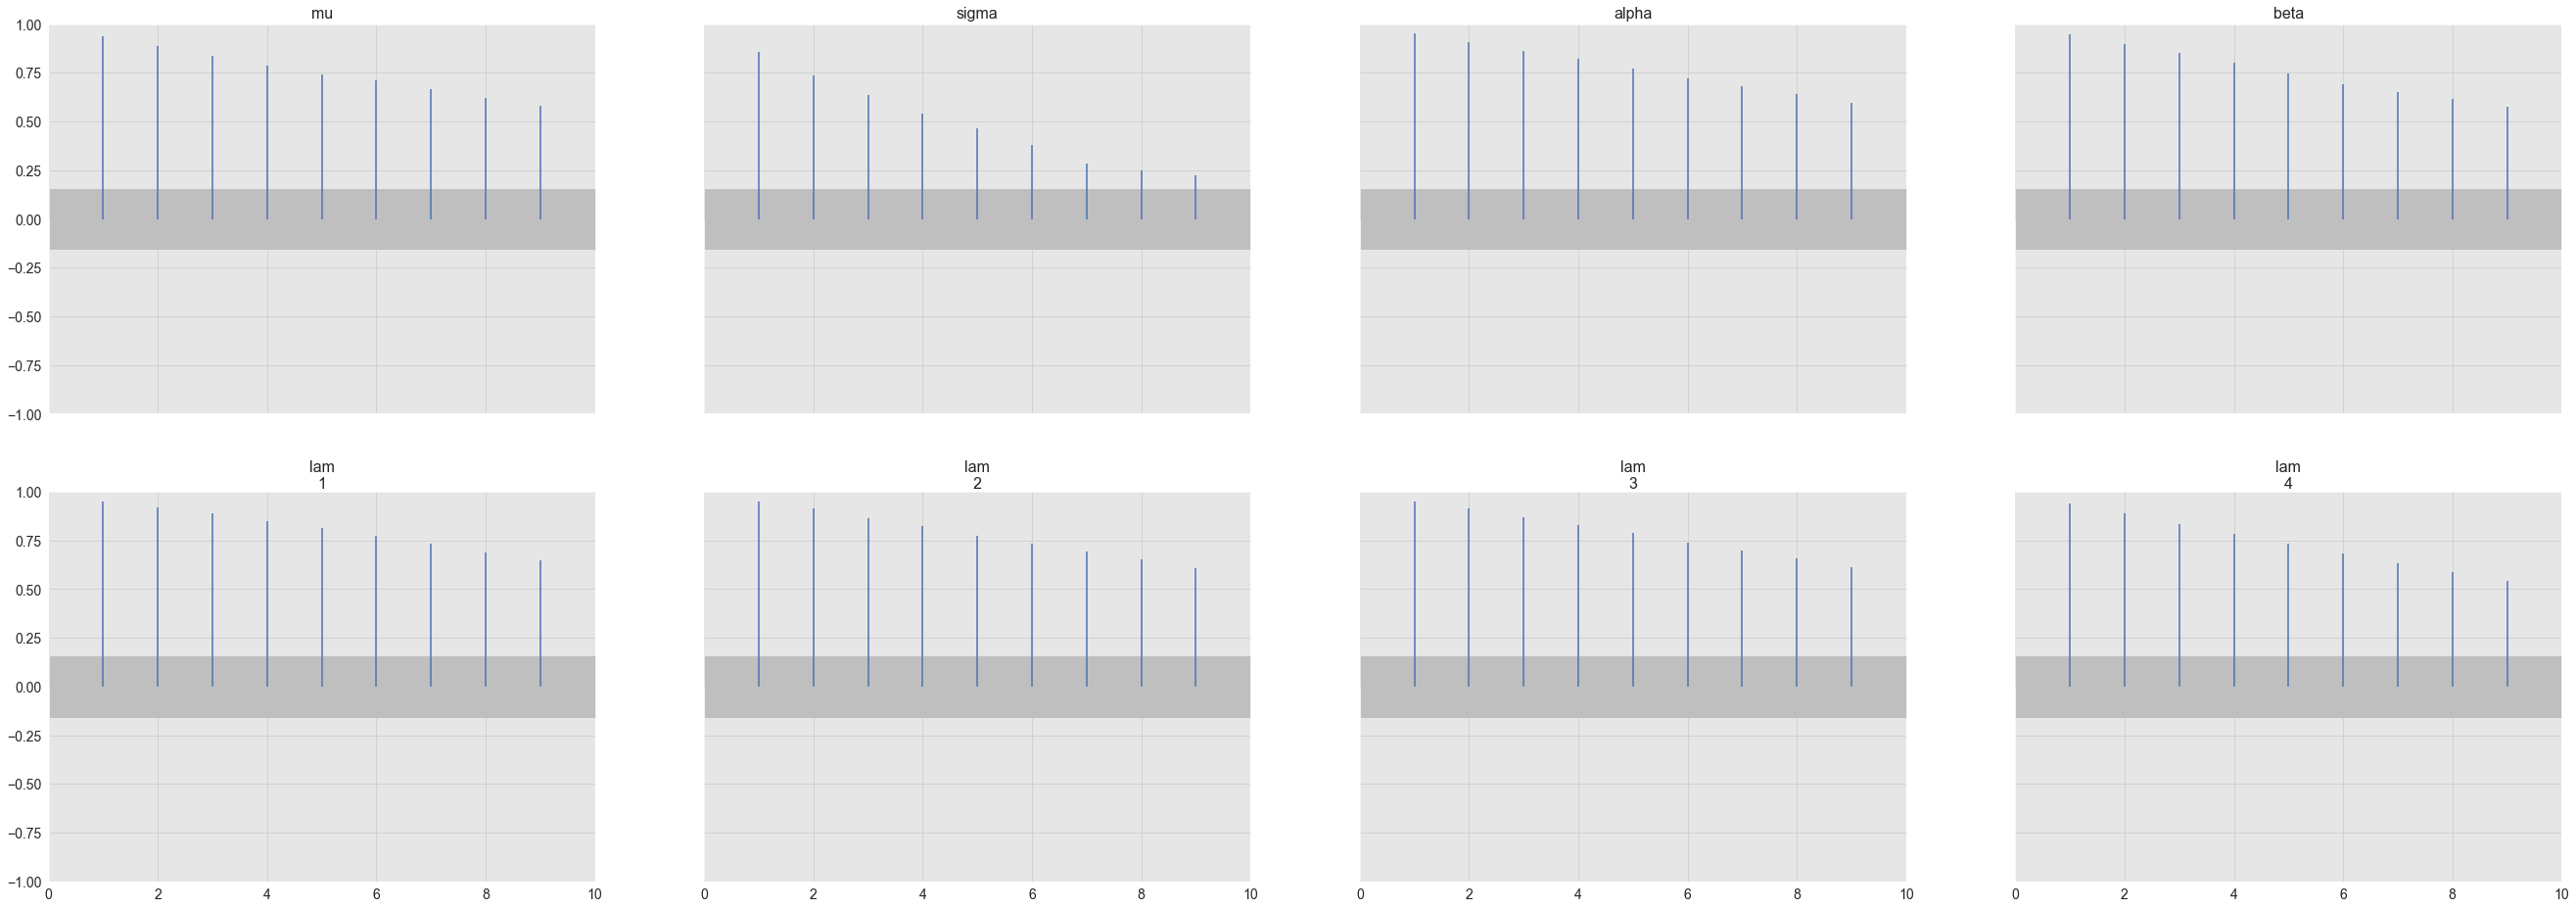

In [112]:
# Auto-correlation
az.plot_autocorr(data=cookies_trace, combined=True, max_lag=10);

In [113]:
stats_df = pd.concat([
    pd.DataFrame(az.loo(data=cookies_trace)),
    pd.DataFrame(az.waic(data=cookies_trace))
])
stats_df.columns = ['values']

stats_df 

C:\Users\ArtSe\AppData\Local\Programs\Python\Python38\lib\site-packages\arviz\stats\stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\ArtSe\AppData\Local\Programs\Python\Python38\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,values
loo,-2531.587743
loo_se,65.833816
p_loo,703.58792
n_samples,160
n_data_points,500
warning,True
loo_i,[<xarray.DataArray 'loo_i' ()>\narray(-2.65528...
pareto_k,[<xarray.DataArray 'pareto_shape' ()>\narray(1...
loo_scale,log
waic,-2547.177536


Другой способ диагностики модели HCM это energy plot, [arviz.plot_energy](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_energy.html)

(для ознакомления[The Geometric Foundations of Hamiltonian Monte Carlo](https://arxiv.org/abs/1410.5110))

В данной визуализации мы смотрим на *marginal and energy transition plots*, чем больше площадь пересечения, тем лучше.

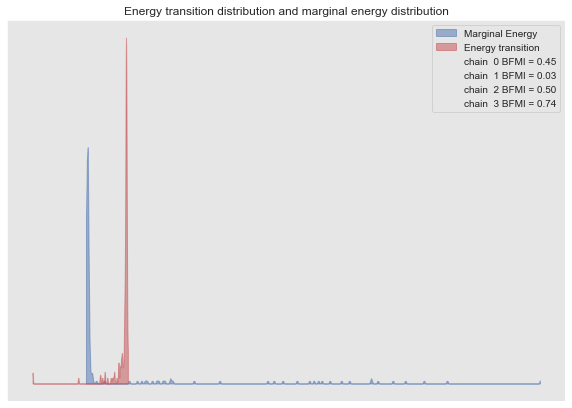

In [114]:
fig, ax = plt.subplots()

az.plot_energy(
    data=cookies_trace,
    fill_color=('C0', 'C3'),
    fill_alpha=(0.5, 0.5),
    ax=ax
)
ax.set(
    title='Energy transition distribution and marginal energy distribution'
);

### Posterior Predictive Distribution

Визуализация предикта модели

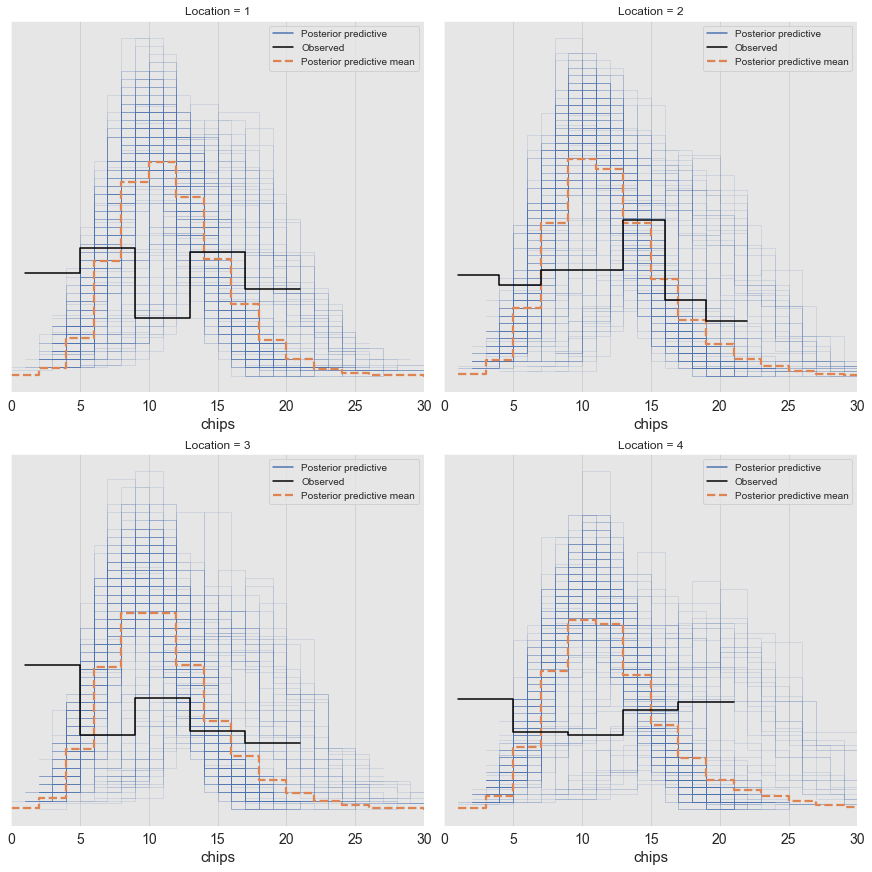

In [115]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(12, 12),
    constrained_layout=True
)

axes = axes.flatten()

for i, location in enumerate(locations):
    ax = axes[i]
    az.plot_ppc(
        data=posterior_predictive,
        coords={
            'obs': np.where(locations[location_idx] == location)
        },
        ax=ax
    )
    ax.legend(loc='upper right')
    ax.set(
        title=f'Location = {location}',
        xlabel='chips',
        xlim=(0, 30)
    )

Сравним наш сэмпл с результатом (по средним значениям)

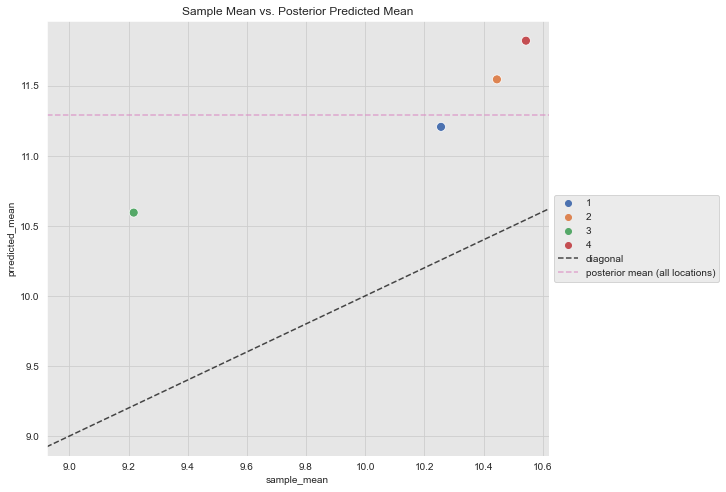

In [117]:
posterior_predictive_mean_lam = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    .lam \
    .mean(axis=1)

posterior_predictive_mean_all_lam = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw', 'location')) \
    .lam \
    .mean()

fig, ax = plt.subplots(figsize=(9, 8))

cookies \
    .groupby('location', as_index=False) \
    .agg(sample_mean=('chips', np.mean)) \
    .assign(prredicted_mean = posterior_predictive_mean_lam) \
    .pipe((sns.scatterplot, 'data'),
        x='sample_mean',
        y='prredicted_mean',
        hue='location',
        palette=sns_c[:4],
        s=80,
        ax=ax
    )

ax.axline(
    xy1=(9, 9),
    slope=1,
    color='black',
    linestyle='--',
    alpha=0.7,
    label='diagonal'

)
ax.axhline(
    y=posterior_predictive_mean_all_lam,
    color=sns_c[6],
    linestyle='--',
    alpha=0.7,
    label='posterior mean (all locations)'
)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(
    title='Sample Mean vs. Posterior Predicted Mean',
);

### Predict

Рассмотрим `location =1`. Мы хотим узнать, что следующее действие в локации создаст $7$ chips
Фактическое распределение $\lambda$ на по всем локациям

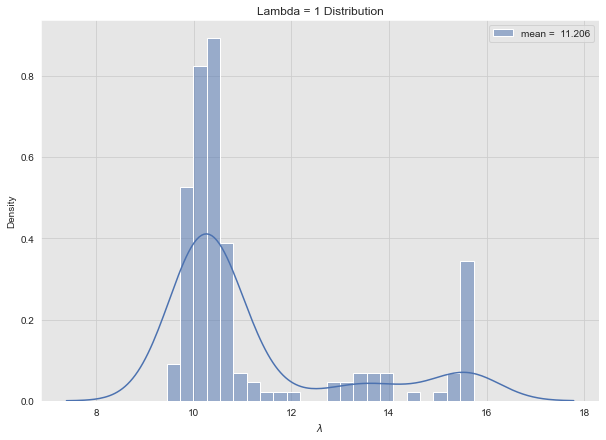

In [118]:
# Set location.
loc = 1
# Get posterior samples.
lambda_loc = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['lam'][loc - 1, :].values

# Plot distribution.
fig, ax = plt.subplots()
sns.histplot(
    x=lambda_loc,
    stat='density',
    color=sns_c[0],
    alpha=0.5,
    label=f'mean = {lambda_loc.mean(): 0.3f}',
    ax=ax
)
sns.kdeplot(
    x=lambda_loc,
    color=sns_c[0],
    ax=ax
)
ax.legend()
ax.set(title=f'Lambda = {loc} Distribution', xlabel='$\lambda$');

Используем Poisson distribution для определения

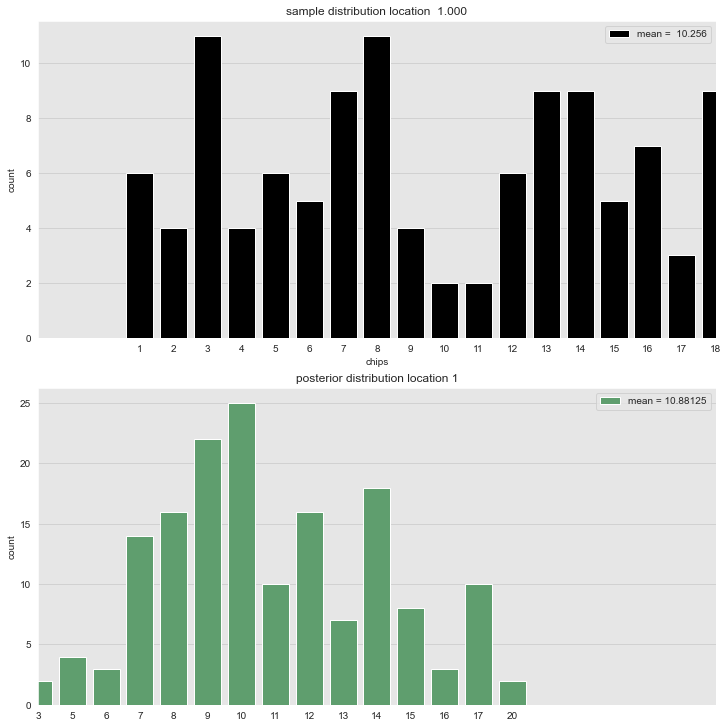

In [119]:
SEED = 5
np.random.seed(SEED)


samples_loc = np.random.poisson(lam=lambda_loc)

# Plot samples vs posterior distribution.
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 10), constrained_layout=True
)
sns.countplot(
    x='chips',
    data=cookies.query(f'location == {loc}'),
    color='black',
    label=f'mean = {cookies.query(f"location == {loc}")["chips"].mean(): 0.3f}',
    ax=ax[0]
)
ax[0].legend(loc='upper right')
ax[0].set(
    title=f'sample distribution location {loc: 0.3f}',
    xlim=(-3, 17)
)
sns.countplot(
    x=samples_loc,
    color=sns_c[2],
    label=f'mean = {samples_loc.mean()}',
    ax=ax[1]
)
ax[1].legend(loc='upper right')
ax[1].set(
    title=f'posterior distribution location {loc}',
    xlim=(0, 20)
);

Расчитаем вероятность того, что будет 7

In [120]:
(samples_loc < 7).astype(float).mean()

0.05625

Расчет с использованием нашего `posterior_predictive` из модели

In [121]:
samples_loc = posterior_predictive \
    .posterior_predictive \
    .stack(sample=('chain', 'draw')) \
    ['likelihood'][locations[location_idx] == loc] \
    .values \
    .flatten()

(samples_loc < 7).astype(float).mean()

0.09271694214876033

## Погрузиться в материал

### Bayesian Statistics

- [Bayesian Analysis with Python (Second edition), ](https://github.com/aloctavodia/BAP)

- [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/)

- [A First Course in Bayesian Statistical Methods, Peter D. Hoff](http://www.springer.com/us/book/9780387922997)

- [An Introduction to Bayesian Analysis: Theory and Methods, Ghosh, Jayanta K., Delampady, Mohan, Samanta, Tapas](http://www.springer.com/la/book/9780387400846)

- [The Geometric Foundations of Hamiltonian Monte Carlo](https://arxiv.org/abs/1410.5110)

### PyMC3

- [Documentation](https://pymc-devs.github.io/pymc3/index.html)

- [Probabilistic Programming in Python using PyMC, John Salvatier, Thomas Wiecki, Christopher Fonnesbeck](https://arxiv.org/abs/1507.08050)